In [1]:
# FULL SCRIPT - SOME STUFF HERE WAS NOT USED IN THE FINAL PAPER
# LIKE R3.VOLUME AND THE NORMALITY TESTS OF DISPLACEMENT LENGTH
# 
##############################################################################
# Script used in the paper:
# Dune migration and volume change from airborne LiDAR, terrestrial LiDAR 
# and Structure from Motion--Multi View Stereo
# by
# Carlos H. Grohmann et al - 2019/2020
# guano (at) usp (dot) br
# Institute of Energy and Environment - University of Sao Paulo
#
# Please check the GitHub repo for the final reference to the paper
##############################################################################

In [2]:
# external file 'azim.py' has the function to calculate azimuth and length of lines

In [3]:
# Shapefiles provided with this script:
# area_dem - mask for ALS and SfM interpolation and comparison
# area_volume - mask for volume calculation (ALS and SfM)
# area_dunefield_als - mask for the entire dunefield (ALS coverage)
# area_tls - mask of TLS survey area
# area_tls_sfm - mask used to constrain random points (TLS x SfM)
# crests_als_2010 - crestlines of 2010 (ALS)
# crests_sfm_2019 - crestlines of 2019 (SfM)
# displacement_crests_2010_2019 - lines connecting 2010 and 2019 crests

In [4]:
# Point cloud data used in this paper is available via OpenTopography
# Airborne LiDAR (2010) - http://dx.doi.org/10.5069/G9DN430Z
# Sfm-MVS (2019) - http://dx.doi.org/10.5069/G9DV1H19
# Terrestrial LiDAR (2019) - 

In [5]:
# Note on LiDAR data used in this paper:
# my GRASS wasn't working witb LibLAS for direct LAS import, so I converted to TXT.
# depending on the GRASS installation, you can use v.in.lidar or v.in.pdal as well

In [6]:
# import python libraries
import sys, os, itertools
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import subprocess
from IPython.display import Image # can use this to display GRASS maps
# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import linregress

In [7]:
# import module to calculate azimuth of lines -- requires python GDAL/OGR libraries 
# in my mac, I needed to set this or jupyter wouldn't find the ogr module:
sys.path.append('/usr/local/opt/gdal2-python/lib/python2.7/site-packages')
import azim

In [8]:
# helper func: round to nearest 5
def round5(x):
    rounded = int(round(x/5.0)*5.0)
    return rounded

In [9]:
# error measurements
def err_mse(x1, x2, axis=0):
    """mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean((x1-x2)**2, axis=axis)

def err_rmse(x1, x2, axis=0):
    """root mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.sqrt(err_mse(x1, x2, axis=axis))

def err_mae(x1, x2, axis=0):
    """mean absolute error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean(np.abs(x1-x2), axis=axis)

In [10]:
def fdr(df):
    ''' Freedman–Diaconis rule to calculate optimal bin size of histograms
    '''
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    len_max = df.max()
    len_min = df.min()
    len_n = len(df)
    IQR = q75 - q25
    bin_width = 2. * IQR * (len_n)**(-1./3.)
    nbins = (len_max - len_min)/bin_width
    return int(nbins)

In [11]:
# aux func
def raster_as_array(raster):
    ''' return GRASS raster as numpy array - remove null values '''
    grass.run_command('g.region', raster=raster, flags='a')
    raster_array = garray.array()
    raster_array.read(raster, null=np.nan)
    raster_array_flat = raster_array.flatten(order='C')
    raster_1d = raster_array_flat[~np.isnan(raster_array_flat)]
    return raster_1d

In [12]:
# matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline

In [13]:
# create GRASS GIS runtime environment
# with this, you can run GRASS without startig a shell/gui session
gisbase = subprocess.check_output(["grass76", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass
import grass.script.setup as gsetup
import grass.script.array as garray
import grass.script.vector as gvect

In [14]:
# set GRASS GIS session data
# I use two systems, so this makes things a bit easier
if sys.platform == "linux" or sys.platform == "linux2":
    rcfile = gsetup.init(gisbase, "/mnt/sda/grassdata/", "utm", "garopaba_22J")
elif sys.platform == "darwin":
    rcfile = gsetup.init(gisbase, "/Volumes/MacintoshHD2/grassdata/", "utm", "garopaba_22J")
# elif platform == "win32":
    # Windows...
    
# grass.message('Current GRASS GIS 7 environment:')
# print grass.gisenv()

In [15]:
# overwrite for GRASS modules
ow = True

In [16]:
# check region
# grass.parse_command('g.region', flags='pg')
# grass.run_command('g.region', flags='pg')

In [17]:
# Data dir 
# use this to set different paths for different systems
if sys.platform == "linux" or sys.platform == "linux2":
    dataDir = '/mnt/sda/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes/'
elif sys.platform == "darwin":
    dataDir = '/Volumes/MacintoshHD2/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes/'
#     dataDir = '_path_to_your_files_'

In [18]:
###########################################################################
###########################################################################
# 
# Import vector masks, import point clouds as raster to create maps 
# of point density/m2
# 
###########################################################################
###########################################################################

In [19]:
# ------------------------------------------------------------------------
# vector masks
# ------------------------------------------------------------------------

In [20]:
# ALS - entire dune field (polygon, manually digitized)
shp_als_mask = dataDir+'area_garopaba.shp'
mask_als = 'mask_als'

In [21]:
grass.run_command('v.in.ogr', input=shp_als_mask, output=mask_als, flags='o', overwrite=ow)

In [22]:
# TLS - dune field TLS area mask (polygon, manually digitized)
# import points in GRASS with r.in.xyz with 1m resolution, export as tiff, draw polygon in QGIS:
# g.region -pa res=01 w=732187 e=732674 n=6900302 s=6899889
# r.in.xyz --overwrite input=pcloud_tls_20mm.txt output=mdt_tls_2019 method=mean separator=comma
# r.out.gdal --overwrite input=mdt_tls_2019@garopaba_22J output=pcloud_1m.tif format=GTiff
shp_tls_mask = dataDir+'area_tls.shp'
mask_tls = 'mask_tls'

In [23]:
grass.run_command('v.in.ogr', input=shp_tls_mask, output=mask_tls, flags='o', overwrite=ow)

In [24]:
# SfM - dune field area mask (polygon, manually digitized)
shp_sfm_mask = dataDir+'area_dem.shp'
mask_sfm = 'mask_sfm' # mask for clipping (pretty much the SfM area)

In [25]:
grass.run_command('v.in.ogr', input=shp_sfm_mask, output=mask_sfm, flags='o', overwrite=ow)

In [26]:
# ------------------------------------------------------------------------
# create maps of point density / m2, adjust colors (hist equalize)
# ------------------------------------------------------------------------

In [27]:
# ALS
pcloud_als_txt = '_path_to_your_files_/pcloud_als.txt' 
als_density = 'als_density'
grass.run_command('g.region', vector=mask_sfm, res=1, flags='pa')

In [28]:
grass.run_command('r.in.xyz', input=pcloud_als_txt, output=als_density, method='n', separator='comma', overwrite=ow) 
grass.run_command('r.null', map=als_density, setnull=0)
grass.run_command('r.colors', map=als_density, color='viridis', flags='e')

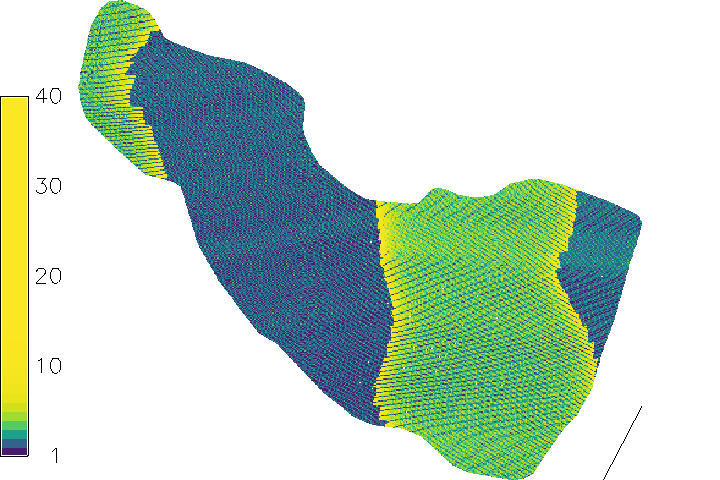

In [29]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=als_density)
grass.run_command('d.vect', map=mask_sfm, fill_color='none')
grass.run_command('d.legend', raster=als_density, at='5,80,0,4', flags='sf')
Image('view.png') 

In [30]:
grass.run_command('d.mon', stop='png') 

0

In [31]:
# SfM - full resolution
pcloud_sfm_full = '_path_to_your_files_/pcloud_sfm_full.txt'
sfm_full_density = 'sfm_full_density'
grass.run_command('g.region', vector=mask_sfm, res=1, flags='pa')

In [32]:
grass.run_command('r.in.xyz', input=pcloud_sfm_full, output=sfm_full_density, method='n', separator='comma', overwrite=ow)
grass.run_command('r.null', map=sfm_full_density, setnull=0)
grass.run_command('r.colors', map=sfm_full_density, color='viridis', flags='e')

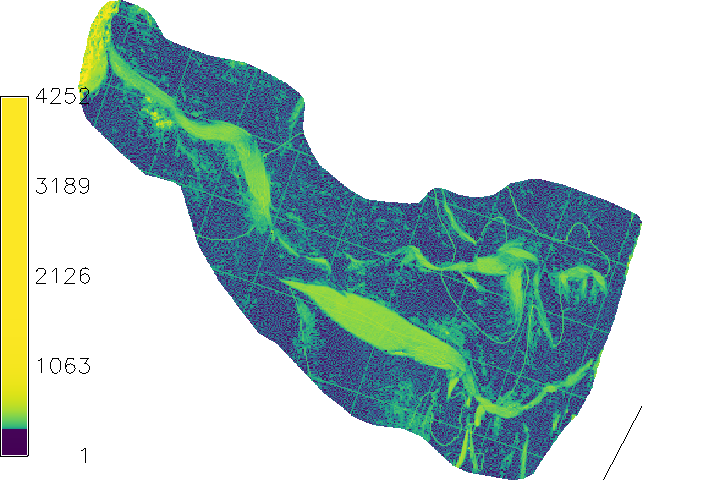

In [33]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_full_density)
grass.run_command('d.vect', map=mask_sfm, fill_color='none')
grass.run_command('d.legend', raster=sfm_full_density, at='5,80,0,4', flags='sf')
Image('view.png') 

In [34]:
grass.run_command('d.mon', stop='png') 

0

In [35]:
# thinned by 125th points
pcloud_sfm_t125 = '_path_to_your_files_/pcloud_sfm_t125.txt'
sfm_t125_density = 'sfm_t125_density'
grass.run_command('g.region', vector=mask_sfm, res=1, flags='pa')

In [36]:
grass.run_command('r.in.xyz', input=pcloud_sfm_t125, output=sfm_t125_density, method='n', separator='comma', overwrite=ow)
grass.run_command('r.null', map=sfm_t125_density, setnull=0)
grass.run_command('r.colors', map=sfm_t125_density, color='viridis', flags='e')

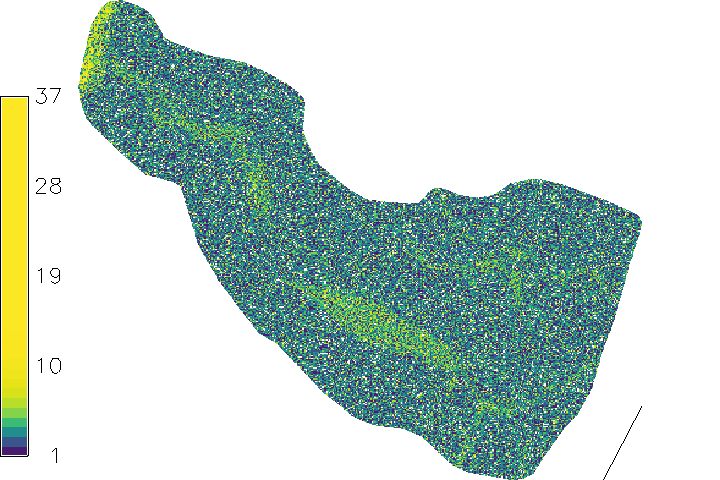

In [37]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_t125_density)
grass.run_command('d.vect', map=mask_sfm, fill_color='none')
grass.run_command('d.legend', raster=sfm_t125_density, at='5,80,0,4', flags='sf')
Image('view.png') 

In [38]:
grass.run_command('d.mon', stop='png') 

0

In [39]:
# TLS
pcloud_tls_txt = '_path_to_your_files_/pcloud_tls_20mm.txt'
tls_density = 'tls_density'
grass.run_command('g.region', vector=mask_tls, res=1, flags='pa')

0

In [40]:
grass.run_command('r.in.xyz', input=pcloud_tls_txt, output=tls_density, method='n', separator='comma', overwrite=ow)
grass.run_command('r.null', map=tls_density, setnull=0)
grass.run_command('r.colors', map=tls_density, color='viridis', flags='e')

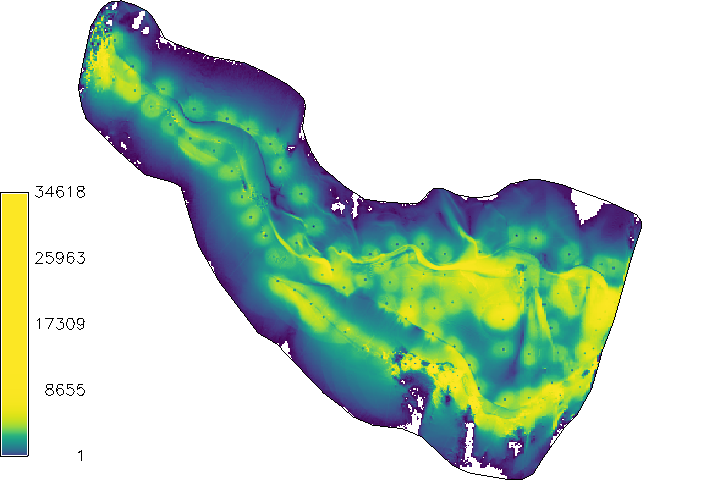

In [41]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=tls_density)
grass.run_command('d.vect', map=mask_tls, fill_color='none')
grass.run_command('d.legend', raster=tls_density, at='5,60,0,4', flags='sf')
Image('view.png') 

In [42]:
grass.run_command('d.mon', stop='png') 

0

In [43]:
# 

In [44]:
###########################################################################
###########################################################################
# 
# Comparison Terrestrial LiDAR / SfM-MVS
# 
###########################################################################
###########################################################################

In [45]:
# Terrestrial LiDAR
# This dataset is available via OpenTopography - 
# exported from FARO Scene as E57, converted to TXT with CloudCompare
# thinned in FARO Scene with 20mm minimum distance between points - 170,141,709 points

In [46]:
# TLS - Terrestrial LiDAR survey
pcloud_tls_txt = '_path_to_your_files_/pcloud_tls_20mm.txt' 

In [47]:
# ------------------------------------------------------------------------
# import TLS data as raster (mean val in 10cm), clipped to mask, convert to vector for interpolation
# ------------------------------------------------------------------------
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)
tls_mean = 'tls_rinxyz_mean_10cm'

In [48]:
# import as raster using 'mean'
grass.run_command('r.in.xyz', input=pcloud_tls_txt, output=tls_mean, method='mean', separator='comma', overwrite=ow) 
grass.run_command('r.null', map=tls_mean, setnull=0)

In [49]:
# convert to vector
grass.run_command('r.to.vect', input=tls_mean, output=tls_mean, type='point', flags='zt', overwrite=ow)
# grass.parse_command('v.info', map=tls_mean)
# Number of points:       7,028,118

In [50]:
# 

In [51]:
# Sfm-MVS reconstruction of dune field (Agisoft Metashape)
# This dataset is available via OpenTopography - http://dx.doi.org/10.5069/G9DV1H19
# 
# convert LAS to TXT (run this in a terminal):
# cd _path_to_your_files_
# las2txt pcloud_sfm.las --parse xyz --precision 3 3 2 -o pcloud_sfm_full.txt
pcloud_sfm_tlsarea_txt = '_path_to_your_files_/pcloud_sfm_full.txt' 

In [52]:
# ------------------------------------------------------------------------
# import SfM data as raster (mean val in 10cm), clipped to mask, convert to vector for interpolation
# ------------------------------------------------------------------------
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)
sfm_mean = 'sfm_rinxyz_mean_10cm'

In [53]:
# import as raster using 'mean'
grass.run_command('r.in.xyz', input=pcloud_sfm_tlsarea_txt, output=sfm_mean, method='mean', separator='comma', overwrite=ow) 
grass.run_command('r.null', map=sfm_mean, setnull=0)

In [54]:
# convert to vector
grass.run_command('r.to.vect', input=sfm_mean, output=sfm_mean, type='point', flags='zt')
# grass.parse_command('v.info', map=sfm_mean)
# Number of points:       8039750 

In [55]:
# ------------------------------------------------------------------------
# Interpolate TLS and SfM DEMs, create shaded relief images
# ------------------------------------------------------------------------

In [56]:
# settings for interpolation, shaded reliefs, names for the files
method='bilinear'
step = 0.4
altitude = 30
azimuth = 25
az_txt = '{:>03.0f}'.format(azimuth)

dem_tls_10cm = 'tls_rinxyz_mean_10cm_' + method + '_step_' + str(step)
dem_tls_10cm_shade = dem_tls_10cm + '_shade_' + az_txt + '_' + str(altitude)

dem_sfm_10cm = 'sfm_rinxyz_mean_10cm_' + method + '_step_' + str(step)
dem_sfm_10cm_shade = dem_sfm_10cm + '_shade_' + az_txt + '_' + str(altitude)

diff_sfm_tls_10cm = 'diff_10cm_sfm_tls'
diff_sfm_tls_10cm_shade = diff_sfm_tls_10cm + '_shade_' + az_txt + '_' + str(altitude)

In [57]:
# set region and mask
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [58]:
# interpolate TLS - 10cm
grass.run_command('v.surf.bspline', input=tls_mean, raster_output=dem_tls_10cm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [59]:
# interpolate SfM - 10cm
grass.run_command('v.surf.bspline', input=sfm_mean, raster_output=dem_sfm_10cm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [60]:
# DEM of Difference - TLS minus SfM
grass.mapcalc('${out} = ${tls} - ${sfm}',
    out=diff_sfm_tls_10cm,
    tls=dem_tls_10cm,
    sfm=dem_sfm_10cm,
    overwrite = True)

In [61]:
# make shaded reliefs and optionally export as tiff
# TLS
grass.run_command('r.relief', input=dem_tls_10cm, output=dem_tls_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_tls_shade, output=dem_tls_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

# SfM
grass.run_command('r.relief', input=dem_sfm_10cm, output=dem_sfm_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_sfm_5cm_shade, output=dem_sfm_5cm_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

# diff 
grass.run_command('r.colors', map=diff_sfm_tls_10cm, color='differences')
grass.run_command('r.relief', input=diff_sfm_tls_10cm, output=diff_sfm_tls_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=diff_sfm_tls_shade, output=diff_sfm_tls_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

In [62]:
# ------------------------------------------------------------------------
# Generate random points, sample DEMs
# ------------------------------------------------------------------------

In [63]:
# import mask to constrain random points 
# (excludes) vegetations and areas without TLS data
shp_tls_sfm = dataDir + 'area_tls_sfm.shp'
mask_tls_sfm = 'mask_tls_sfm'

In [64]:
grass.run_command('v.in.ogr', input=shp_tls_sfm, output=mask_tls_sfm, flags='o', overwrite=ow)

In [65]:
seed = 654321
npoints = 2000
rpoints = 'rpoints'

In [66]:
grass.run_command('v.random', output=rpoints, npoints=npoints, restrict=mask_tls_sfm, seed=seed, overwrite=ow)
grass.run_command('v.db.addtable', map=rpoints, columns="tls double, sfm double, diff double")
grass.run_command('v.what.rast', map=rpoints, raster=dem_tls_10cm, column='tls')
grass.run_command('v.what.rast', map=rpoints, raster=dem_sfm_10cm, column='sfm')
grass.run_command('v.what.rast', map=rpoints, raster=diff_sfm_tls_10cm, column='diff')

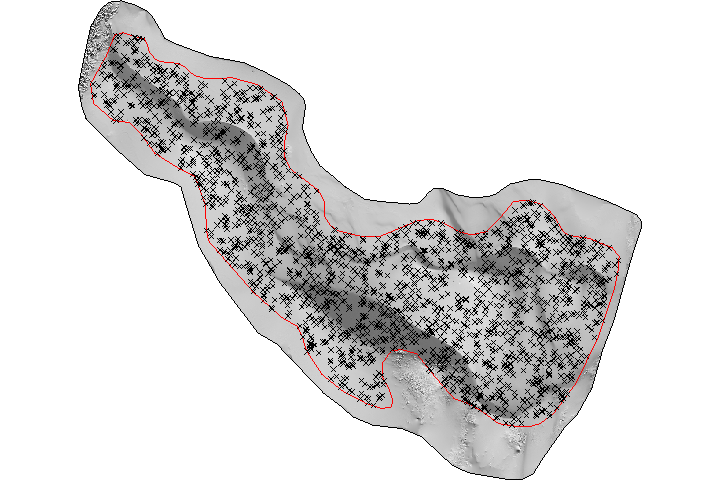

In [67]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_tls_10cm_shade)
grass.run_command('d.vect', map=mask_tls, fill_color='none')
grass.run_command('d.vect', map=mask_tls_sfm, fill_color='none', color='red') # mask for random points
grass.run_command('d.vect', map=rpoints)
Image('view.png') 

In [68]:
grass.run_command('d.mon', stop='png') 

0

In [69]:
# ------------------------------------------------------------------------
# Get attr data, make stats and plots
# ------------------------------------------------------------------------

In [70]:
# read vector from GRASS
elevs = gvect.vector_db_select(rpoints)['values']

In [71]:
gvect.vector_db_select(rpoints)['columns']

['cat', 'tls', 'sfm', 'diff']

In [72]:
# create dataframe, fix data type
# pandas must be newer than 0.22
sfm_tls = pd.DataFrame.from_dict(elevs, orient='index', columns=['cat','tls','sfm','diff'])
sfm_tls['tls'] = sfm_tls['tls'].astype(float)
sfm_tls['sfm'] = sfm_tls['sfm'].astype(float)
sfm_tls['diff'] = sfm_tls['diff'].astype(float)
# sfm_tls.describe()

In [73]:
# calculate stats for each DEM
# could've used pd.describe() but I wanted skew and kurtosis as well
df_stats = pd.DataFrame(columns = ['min','max','mean','median','stddev','skew','kurt','p25','p75'], index=['tls','sfm','diff'])
for dem in ['tls','sfm','diff']:
    rast_max = sfm_tls[dem].max()
    rast_min = sfm_tls[dem].min()
    rast_mean = sfm_tls[dem].mean()
    rast_median = sfm_tls[dem].quantile(q=0.50)
    rast_stddev = sfm_tls[dem].std()
    rast_p25 = sfm_tls[dem].quantile(q=0.25)
    rast_p75 = sfm_tls[dem].quantile(q=0.75)
    rast_skew = sfm_tls[dem].skew()
    rast_kurt = sfm_tls[dem].kurtosis()
    df_stats.loc[dem] = [rast_min,rast_max,rast_mean,rast_median,rast_stddev,rast_skew,rast_kurt,rast_p25,rast_p75]

df_stats
# print df_stats.to_latex(float_format="{:4.2f}".format)
# \begin{tabular}{llllllllll}
# \toprule
# {} &    min &    max &   mean & median & stddev &   skew &   kurt &    p25 &    p75 \\
# \midrule
# tls  &  8.518 & 36.128 & 23.749 & 24.641 &  6.436 & -0.217 & -0.749 & 18.238 & 28.247 \\
# sfm  &  8.684 & 36.104 & 23.849 & 24.796 &  6.410 & -0.231 & -0.755 & 18.393 & 28.327 \\
# diff & -0.623 &  0.226 & -0.100 & -0.103 &  0.129 & -0.259 &  0.119 & -0.196 &  0.007 \\
# \bottomrule
# \end{tabular}

,min,max,mean,median,stddev,skew,kurt,p25,p75
tls,8.51795,36.1278,23.7488,24.6413,6.43646,-0.216549,-0.748551,18.2376,28.2471
sfm,8.68434,36.1044,23.849,24.7965,6.41034,-0.230788,-0.755286,18.3929,28.327
diff,-0.623076,0.22565,-0.100245,-0.102535,0.129369,-0.259375,0.118626,-0.196481,0.0067143


In [74]:
# how much of the TLS DEM is below the SfM one?
ss.percentileofscore(tuple(sfm_tls['diff']),0)

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


73.7

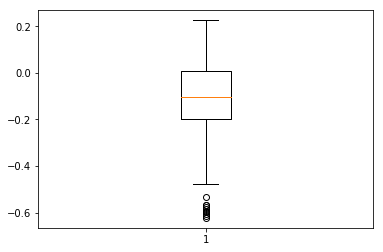

In [75]:
# boxplot 
bp = plt.boxplot(sfm_tls['diff'])
# plt.savefig('diff_boxplot.svg')

In [76]:
# number of outliers
len(bp['fliers'][0]._y)

11

In [77]:
# 

In [78]:
# ------------------------------------------------------------------------
# convert random points map to 3D, for visualization of errors
# ------------------------------------------------------------------------

In [79]:
rpointsZ = rpoints+'_Z'
grass.run_command('v.to.3d', input=rpoints, out=rpointsZ, column='diff', overwrite=ow)

In [82]:
# make new raster of diff only inside the inner mask, for legend display
grass.run_command('r.mask', vector=mask_tls_sfm, overwrite=ow)
diff_sfm_tls_10cm_clip = diff_sfm_tls_10cm+'_clip'
grass.mapcalc('${out} = if(${dem},${dem},null())',
    out=diff_sfm_tls_10cm_clip,
    dem=diff_sfm_tls_10cm,
    overwrite = True)
grass.run_command('r.colors', map=diff_sfm_tls_10cm_clip, color='differences')
grass.run_command('r.mask', flags='r')

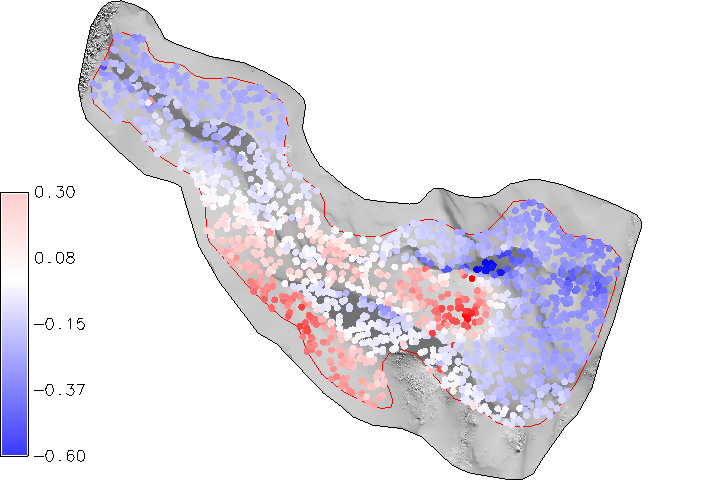

In [85]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_tls_10cm_shade)
grass.run_command('d.vect', map=mask_tls, fill_color='none')
grass.run_command('d.vect', map=mask_tls_sfm, fill_color='none', color='red') # mask for random points
grass.run_command('d.vect', map=rpointsZ, zcolor='differences', icon='basic/circle', color='none', size=7)
grass.run_command('d.legend', raster=diff_sfm_tls_10cm_clip, at='5,60,0,4', range='-0.6,0.3')
Image('view.png') 

In [86]:
grass.run_command('d.mon', stop='png') 

0

In [87]:
grass.run_command('r.info', map=diff_sfm_tls_10cm)

0

In [88]:
# 

In [89]:
# ------------------------------------------------------------------------
# graphics, errors
# ------------------------------------------------------------------------

In [90]:
# histogram of differences
# FDR rule
print ('bins for diff: {:d}'.format(fdr(sfm_tls['diff'])))

bins for diff: 26


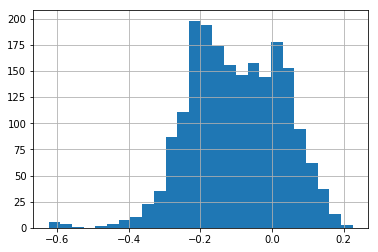

In [91]:
sfm_tls['diff'].hist(bins=26)
# plt.savefig('diff_hist.svg')

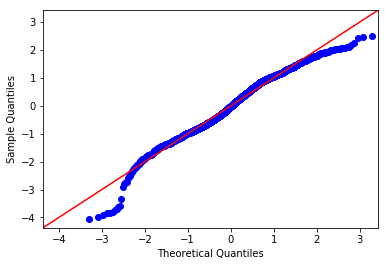

In [92]:
# QQ plot
qqplot(sfm_tls['diff'],fit=True,line='45');

In [93]:
# Shapiro-Wilk normality test
stat, p = ss.shapiro(sfm_tls['diff'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.984, p=0.000
Sample does not look Gaussian (reject H0)


In [94]:
# correlation between TLS and SfM DEMs

slope =  1.003879524672105
intercept =  -0.19276749895513134
r_value =  0.9998054512785631
r_squared =  0.9996109404063312
p_value =  0.0
std_err =  0.0004430741556312821


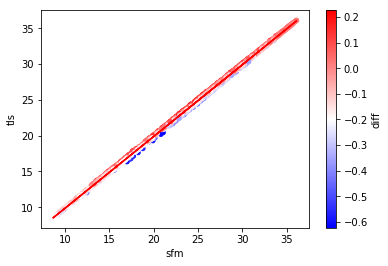

In [95]:
# TLS x interpolated SfM DEM
y = sfm_tls.tls
x = sfm_tls.sfm
slope, intercept, r_value, p_value, std_err = linregress(x, y)

line_y = slope * x + intercept
sfm_tls.plot.scatter(x='sfm',y='tls',c='diff',colormap='bwr')
plt.plot(x, line_y, color="red") 
# plt.savefig('corrplot.svg')

print 'slope = ',slope
print 'intercept = ',intercept
print 'r_value = ',r_value # correlation coefficient
print 'r_squared = ',r_value**2 # coefficient of determination
print 'p_value = ',p_value
print 'std_err = ',std_err

In [96]:
# MAE, RMSE
rmse_tls_sfm = err_rmse(sfm_tls.tls,sfm_tls.sfm)
mae_tls_sfm = err_mae(sfm_tls.tls,sfm_tls.sfm)

print 'RMSE TLS x SfM: ', rmse_tls_sfm
print 'MAE TLS x SfM: ', mae_tls_sfm

RMSE TLS x SfM:  0.16363706458612742
MAE TLS x SfM:  0.13165336075006343


In [97]:
# 

In [98]:
# ------------------------------------------------------------------------
# roughness
# ------------------------------------------------------------------------

In [99]:
# set region and mask
mask_tls = 'mask_tls'
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

0

In [100]:
# settings for roughness, names for the files
w = 5  # window size
op = 'stddev' # neighborhood operation

tls_slope = dem_tls_10cm + '_slope'
sfm_slope = dem_sfm_10cm + '_slope'

tls_rough = tls_slope + '_std_' + str(w) + 'x' + str(w)
sfm_rough = sfm_slope + '_std_' + str(w) + 'x' + str(w)

In [101]:
# slope
grass.run_command('r.slope.aspect', elevation=dem_tls_10cm, slope=tls_slope, overwrite=ow)
grass.run_command('r.slope.aspect', elevation=dem_sfm_10cm, slope=sfm_slope, overwrite=ow)

In [102]:
# # roughness
grass.run_command('r.neighbors', input=tls_slope, output=tls_rough, method=op, size=w, overwrite=ow)
grass.run_command('r.neighbors', input=sfm_slope, output=sfm_rough, method=op, size=w, overwrite=ow)

In [103]:
# set custom colortable, based on viridis
rules='''0 255:255:255
1 253:231:37
3 93:201:98
5 32:144:141
7 58:82:139
9 68:1:84
13 155:0:0
30 155:0:0
'''
# save rules to file
with open('rules.txt', 'w+') as file:
    file.write(rules)

grass.run_command('r.colors', map=tls_rough, rules='rules.txt')
grass.run_command('r.colors', map=sfm_rough, rules='rules.txt')

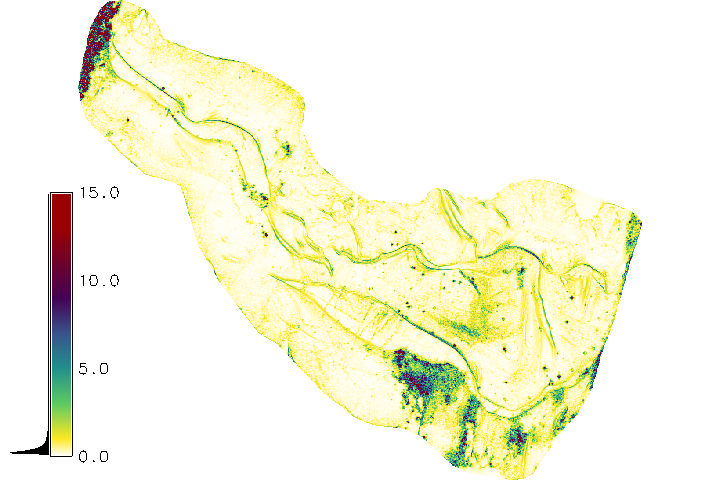

In [104]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=tls_rough)
grass.run_command('d.legend', raster=tls_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [105]:
grass.run_command('d.mon', stop='png') 

0

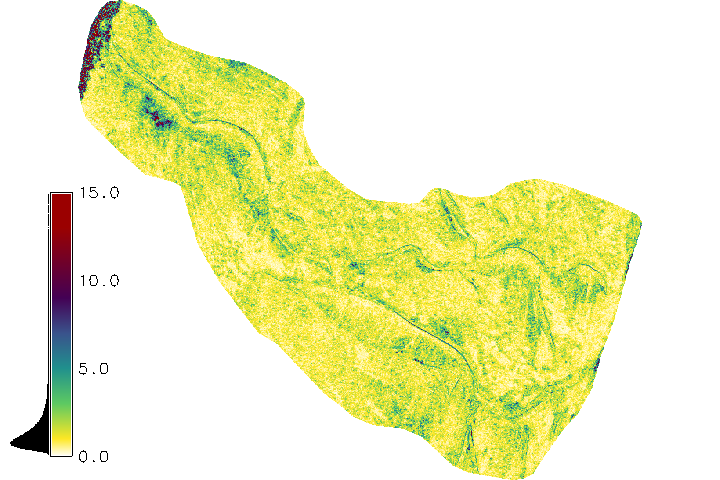

In [106]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_rough)
grass.run_command('d.legend', raster=sfm_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [107]:
grass.run_command('d.mon', stop='png') 

0

In [108]:
# 

In [109]:
# 

In [110]:
###########################################################################
###########################################################################
# 
# comparison Airborne LiDAR / SfM-MVS
# 
###########################################################################
###########################################################################

In [111]:
# Airborne LiDAR survey (2010-09, processed by Geoid ltda.)
# This dataset is available via OpenTopography - http://dx.doi.org/10.5069/G9DN430Z
# convert LAS to TXT (run this in a terminal):
# cd _path_to_your_files_
# las2txt Pontos_Garopaba.las --parse xyz --precision 3 3 2 --first-return-only -o pcloud_als.txt

In [112]:
# LAS - names and files
pc_als = 'pcloud_als_2010'
pc_als_c = 'pcloud_als_2010_clip'
pcloud_als_txt = '_path_to_your_files_/pcloud_als.txt' 

In [113]:
# ------------------------------------------------------------------------
# import ALS data, clip to mask and remove original vector
# ------------------------------------------------------------------------
grass.run_command('v.in.ascii', input=pcloud_als_txt, output=pc_als, separator='comma', x=1, y=2, z=3, flags='ztr', overwrite=ow) 
grass.run_command('v.clip', input=pc_als, output=pc_als_c, clip=mask_sfm, overwrite=ow) # points: 2,380,005
grass.run_command('g.remove', type='vector', name=pc_als, flags='f')

In [114]:
# 

In [115]:
# Sfm-MVS reconstruction of dune field (Agisoft Metashape)
# This dataset is available via OpenTopography - http://dx.doi.org/10.5069/G9DV1H19
# thinned by every 125th point to be at a similar size of the ALS after clipping
# convert LAS to TXT and thin points (run this in a terminal):
# cd _path_to_your_files_
# las2txt pcloud_sfm.las --parse xyz --precision 3 3 2 -t 125 -o pcloud_sfm_t125.txt

In [116]:
# SfM - names and files
pc_sfm = 'pcloud_sfm_2019'
pc_sfm_c = 'pcloud_sfm_2019_clip'
pcloud_sfm_txt = '_path_to_your_files_/pcloud_sfm_t125.txt'

In [117]:
# ------------------------------------------------------------------------
# import SfM data (thinned), clip to mask and remove original vector
# ------------------------------------------------------------------------
grass.run_command('v.in.ascii', input=pcloud_sfm_txt, output=pc_sfm, separator='comma', x=1, y=2, z=3, flags='ztr', overwrite=ow)
grass.run_command('v.clip', input=pc_sfm, output=pc_sfm_c, clip=mask_sfm, overwrite=ow) # points: 2,376,632
grass.run_command('g.remove', type='vector', name=pc_sfm, flags='f')

In [118]:
# ------------------------------------------------------------------------
# Interpolate ALS and SfM DEMs, create shaded relief images
# ------------------------------------------------------------------------

In [129]:
# settings for interpolation, shaded reliefs, name the files, set mask
method='bilinear'
step = 2
altitude = 30
azimuth = 25
az_txt = '{:>03.0f}'.format(azimuth)

dem_als = 'als_50cm_' + method + '_step_' + str(step)
dem_als_shade = dem_als + '_shade_' + az_txt + '_' + str(altitude)

dem_sfm = 'sfm_50cm_' + method + '_step_' + str(step)
dem_sfm_shade = dem_sfm + '_' + '_shade_' + az_txt + '_' + str(altitude)

diff_sfm_als = 'diff_sfm_minus_als'
dem_diff_shade = diff_sfm_als + '_shade_' + az_txt + '_' + str(altitude)

# set region (0.5m resolution 3D) and mask 
n = 6900951.5
s = 6899231.5
w = 731859.0
e = 732783.5
grass.run_command('g.region', n=n,s=s,w=w,e=e,t=60,b=0, res3=0.5, flags='p3a', save='dunes_default', overwrite=ow)
grass.run_command('r.mask', vector=mask_sfm, overwrite=ow)
# grass.run_command('r.mask', flags='r')

In [120]:
# Interpolate ALS 
grass.run_command('v.surf.bspline', input=pc_als_c, raster_output=dem_als, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [121]:
# Interpolate SfM 
grass.run_command('v.surf.bspline', input=pc_sfm_c, raster_output=dem_sfm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [122]:
# DEM of Difference - ALS (2010) minus SfM (2019)
grass.mapcalc('${out} = ${sfm} - ${als}',
    out=diff_sfm_als,
    als=dem_als,
    sfm=dem_sfm,
    overwrite = True)

In [123]:
# make shaded reliefs and export as tiff
# ALS
grass.run_command('r.relief', input=dem_als, output=dem_als_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
grass.run_command('r.out.gdal', input=dem_als_shade, output=dem_als_shade+'.tif', format='GTiff', type='Int16')
# SfM
grass.run_command('r.relief', input=dem_sfm, output=dem_sfm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
grass.run_command('r.out.gdal', input=dem_sfm_shade, output=dem_sfm_shade+'.tif', format='GTiff', type='Int16')
# diff
grass.run_command('r.colors', map=diff_sfm_als, color='differences')
grass.run_command('r.relief', input=diff_sfm_als, output=dem_diff_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
grass.run_command('r.out.gdal', input=dem_diff_shade, output=dem_diff_shade+'.tif', format='GTiff', type='Int16')

In [124]:
# 

In [125]:
# ------------------------------------------------------------------------
# Stats, histograms
# ------------------------------------------------------------------------

In [130]:
# read DSMs as arrays and create dataframe
df_dems = pd.DataFrame()
df_dems['als'] = raster_as_array(dem_als)
df_dems['sfm'] = raster_as_array(dem_sfm)
df_dems['dod'] = raster_as_array(diff_sfm_als)

In [131]:
# calculate stats for each DEM
# could've used pd.describe() but I wanted skew and kurtosis as well
df_stats = pd.DataFrame(columns = ['min','max','mean','median','stddev','skew','kurt','p25','p75'], index=['als','sfm','dod'])
for dem in ['als','sfm','dod']:
    rast_max = df_dems[dem].max()
    rast_min = df_dems[dem].min()
    rast_mean = df_dems[dem].mean()
    rast_median = df_dems[dem].quantile(q=0.50)
    rast_stddev = df_dems[dem].std()
    rast_p25 = df_dems[dem].quantile(q=0.25)
    rast_p75 = df_dems[dem].quantile(q=0.75)
    rast_skew = df_dems[dem].skew()
    rast_kurt = df_dems[dem].kurtosis()
    df_stats.loc[dem] = [rast_min,rast_max,rast_mean,rast_median,rast_stddev,rast_skew,rast_kurt,rast_p25,rast_p75]

df_stats

,min,max,mean,median,stddev,skew,kurt,p25,p75
als,2.6917,58.8792,21.3364,20.649,11.5927,0.505565,-0.410888,11.6437,28.7695
sfm,4.70026,58.5539,22.0576,20.9462,11.213,0.514455,-0.508238,12.3443,29.4244
dod,-16.7982,18.3959,0.72122,0.934228,3.5123,-0.0757305,2.44664,-0.833068,2.36949


In [132]:
# export stats to latex
# print df_stats.to_latex(float_format="{:4.2f}".format)

# \begin{tabular}{llllllllll}
# \toprule
# {} &    min &   max &  mean & median & stddev &  skew &  kurt &   p25 &   p75 \\
# \midrule
# als &   2.69 & 58.88 & 21.34 &  20.65 &  11.59 &  0.51 & -0.41 & 11.64 & 28.77 \\
# sfm &   4.70 & 58.55 & 22.06 &  20.95 &  11.21 &  0.51 & -0.51 & 12.34 & 29.42 \\
# dod & -16.80 & 18.40 &  0.72 &   0.93 &   3.51 & -0.08 &  2.45 & -0.83 &  2.37 \\
# \bottomrule
# \end{tabular}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1222e7850>,
      dtype=object)

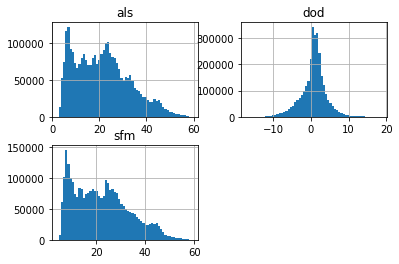

In [133]:
# quick histograms, bins=60 as this is the approx range of elevation
df_dems.hist(bins=60)

In [134]:
# use Freedman–Diaconis rule to calculate optimal bin size? -- TOO MUCH
print ('bins for ALS: {:d}'.format(fdr(df_dems.als)))
print ('bins for SfM: {:d}'.format(fdr(df_dems.sfm)))
print ('bins for DoD: {:d}'.format(fdr(df_dems.dod)))

bins for ALS: 235
bins for SfM: 226
bins for DoD: 789


In [135]:
# make individual histograms and save as svg (in dataDir)
def do_hist(dem,nbins,out_dir):
    '''make histograms, save as svg in out_dir'''
    fileOut = out_dir + 'hist_' + dem + '.svg'
    df_dems[dem].hist(bins=nbins, label=dem)
    plt.title('Elevation histogram, '+ dem)
    plt.xlabel('Elevation')
    plt.ylabel('Cell count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fileOut)
    plt.clf()
    plt.cla()
    
# will use same number of bins for ALS and SfM
figDir = '_path_to_your_files_'
do_hist('als',nbins=60,out_dir=figDir)
do_hist('sfm',nbins=60,out_dir=figDir)
do_hist('dod',nbins=40,out_dir=figDir)

In [136]:
# 

In [137]:
# ------------------------------------------------------------------------
# Volume calculation with r.volume and r3.stats
# ------------------------------------------------------------------------

In [138]:
mask_vol = 'mask_vol'
grass.run_command('g.region', flags='p3a')

0

In [139]:
# ALS LiDAR

In [140]:
# r.volume
# here we use the 'mask_vol' raster as a clump raster to sum the volume of each cell
als_rvol_txt = grass.read_command('r.volume',input=dem_als, clump=mask_vol)

# print (als_rvol_txt)
# Volume report on data from <dem_als_bilinear_step_2> using clumps on <mask_sfm> raster map
# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1     24.08  36140462 1500908   732324.75  6900039.25       9035115.45
# -----------------------------------------------------------------------------
#                                                 Total Volume =     9035115.45

In [141]:
# rast3elev 
# here we need to create a new raster (with the area of 'mask_vol')
# and then convert it to 3D raster
dem_als_clip = dem_als+'_clip_vol'
grass.mapcalc('${out} = if(${clip},${als},null())',
    out=dem_als_clip,
    clip=mask_vol,
    als=dem_als,
    overwrite = True)

In [142]:
dem3d_als = dem_als+'_clip_3d'
grass.run_command('r.to.rast3elev', input=mask_vol, elevation=dem_als_clip, output=dem3d_als, lower=0, overwrite=True)

In [143]:
r3volume_als = grass.read_command('r3.stats', input=dem3d_als, nsteps=1)
for i in r3volume_als.split('\n'):
    print(i)
# Sum of non Null cells:
#     Volume =   9128977.625
#     Percentage =   9.568
#     Cell count = 73031821

In [144]:
# SfM DEM

In [145]:
# r.volume
sfm_rvol_txt = grass.read_command('r.volume',input=dem_sfm, clump=mask_vol)

# print (sfm_rvol_txt)
# Volume report on data from <dem_sfm_bilinear_step_2> using clumps on <mask_sfm> raster map
# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1     24.20  36324742 1500908   732324.75  6900039.25       9081185.49
# -----------------------------------------------------------------------------
#                                                 Total Volume =     9081185.49

In [146]:
# rast3elev 
dem_sfm_clip = dem_sfm+'_clip_vol'
grass.mapcalc('${out} = if(${clip},${sfm},null())',
    out=dem_sfm_clip,
    clip=mask_vol,
    sfm=dem_sfm,
    overwrite = True)

In [147]:
dem3d_sfm = dem_sfm+'_clip_3d'
grass.run_command('r.to.rast3elev', input=mask_vol, elevation=dem_sfm_clip, output=dem3d_sfm, lower=0, overwrite=True)

In [148]:
r3volume_sfm = grass.read_command('r3.stats', input=dem3d_sfm, nsteps=1)
for i in r3volume_sfm.split('\n'):
    print(i)
# Sum of non Null cells:
#     Volume =   9174962.125
#     Percentage =   9.617
#     Cell count = 73399697

In [149]:
# percent change of volume with r.volume and r3.stats

In [150]:
# ALS
als_rvol = 9035115.450
als_r3v =  9128977.625
print (100 * (als_r3v - als_rvol) / als_rvol)
# 1.03885971927

1.03885971927


In [151]:
# SfM
sfm_rvol = 9081185.490
sfm_r3v =  9174962.125
print (100 * (sfm_r3v - sfm_rvol) / sfm_rvol)
# 1.03264750074

1.03264750074


In [152]:
# difference
diff_rvol = grass.read_command('r.volume',input=diff_sfm_als, clump=mask_vol)

# print(diff_rvol)
# Volume report on data from <diff_sfm_minus_als> using clumps on <mask_vol> raster map

# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1      0.12    184280 1500908   732324.75  6900039.25         46070.04
# -----------------------------------------------------------------------------
#                                                 Total Volume =       46070.04

In [153]:
print(sfm_rvol - als_rvol)

46070.04


In [154]:
# ------------------------------------------------------------------------
# Displacement of dune crests
# ------------------------------------------------------------------------

In [155]:
# displacement lines file
shp_lin = dataDir+'displacement_crests_2010_2019.shp'

In [157]:
# azimuth and length are calculated by functions in 'azim.py'
azim, leng = azim.azim(shp_lin)

('Linear features in file:', 164)

('len azimuth:', 164)


In [158]:
# put azim, length in dataframe
df_lin = pd.DataFrame(columns=['az','len'])

In [159]:
df_lin['az'] = azim
df_lin['len'] = leng

In [160]:
df_lin.describe()    

,az,len
count,164.000000,164.000000
mean,77.134459,44.337216
std,71.471807,16.624351
min,28.300756,6.589562
25%,36.811825,32.311424
50%,38.973451,44.779536
75%,48.271621,53.505507
max,223.285070,84.345960


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1251f9ad0>,
      dtype=object)

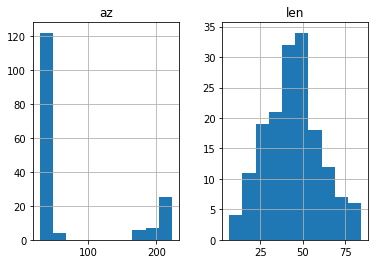

In [161]:
df_lin.hist()

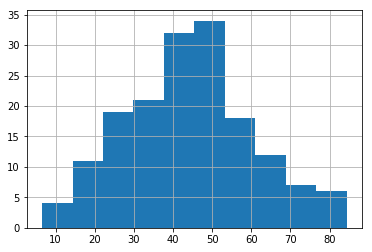

In [162]:
# nbins with Freedman–Diaconis rule
nbins = fdr(df_lin['len'])
df_lin['len'].hist(bins=nbins)

In [163]:
# Normality tests for displacement length
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

In [164]:
data = df_lin['len']

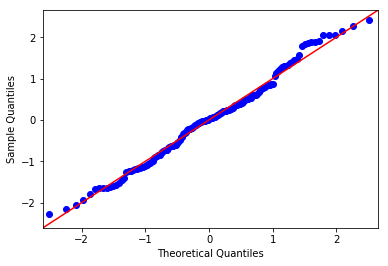

In [165]:
# QQ plot
qqplot(data,fit=True,line='45');

In [166]:
# Shapiro-Wilk Test
# from scipy.stats import shapiro
# normality test
stat, p = ss.shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.988, p=0.153
Sample looks Gaussian (fail to reject H0)


In [167]:
# D’Agostino’s K^2 Test
# from scipy.stats import normaltest
stat, p = ss.normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=1.055, p=0.590
Sample looks Gaussian (fail to reject H0)


In [168]:
# Anderson-Darling Test
# from scipy.stats import anderson
# normality test
result = ss.anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.554
15.000: 0.563, data looks normal (fail to reject H0)
10.000: 0.641, data looks normal (fail to reject H0)
5.000: 0.769, data looks normal (fail to reject H0)
2.500: 0.897, data looks normal (fail to reject H0)
1.000: 1.067, data looks normal (fail to reject H0)


In [169]:
# from scipy.stats import kstest
ss.kstest(data, 'lognorm', args=(1,))

KstestResult(statistic=0.9780098475326018, pvalue=0.0)

In [170]:
# ------------------------------------------------------------------------
# Azimuth analysis
# ------------------------------------------------------------------------

In [171]:
# Looking at the histogram, we see that the azimuth 
# of displacement lines are clustered in the NE and SW quadrants.
# Since azimuth is calculated from the endpoints of lines, 
# we get both quadrants depending on how teh line was drawn. 
# The dune field migrates southward, so we need to convert
# the azimuth values to south quadrants (SE, SW)
azimMod = [] 
for az in df_lin['az']:
    if 0.0 < az <= 90.0: # NE quadrant
        azimMod.append(az + 180.0)
    elif 270.0 <= az <= 360.0: # NW quadrant
        azimMod.append(az + 180.0)
    else:
        azimMod.append(az)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139579210>]],
      dtype=object)

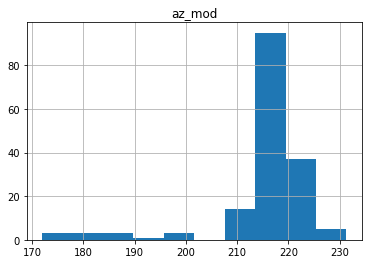

In [172]:
# make a dataframe just to plot the histogram easily
az_m = pd.DataFrame(azimMod, columns =['az_mod']) 
az_m.hist()

In [173]:
# calculate mean direction
# from Fisher 1993, Statistical Analyis of circular data, p.31
az_rad = np.deg2rad(azimMod)
sinTheta = np.sin(az_rad)
cosTheta = np.cos(az_rad)
C = np.sum(cosTheta)
S = np.sum(sinTheta)

ThetaBar = np.arctan2(C,S)
ThetaBarDeg = np.rad2deg(ThetaBar)

In [174]:
# convert from arctan2 degrees to azimuth 
# (note: modulo 360 does not work for this)
# https://stackoverflow.com/a/25398191/4984000
if ThetaBarDeg > 90.0:
    ThetaBarDeg = 450.0 - ThetaBarDeg
else:
    ThetaBarDeg = 90.0 - ThetaBarDeg

In [175]:
# mean direction of dune displacement
ThetaBarDeg

215.55194503485

In [176]:
# ------------------------------------------------------------------------
# Topographic profiles
# ------------------------------------------------------------------------

In [177]:
coords=(732000,6899600,732470,6900445)

In [178]:
# ALS
p_als = grass.read_command('r.profile', input=dem_als , output='-', coordinates=coords, res=0.5, null='*') 
p_als_x = p_als.split()[0::2]
p_als_y = p_als.split()[1::2]
als_x=[float(num) for num in p_als_x]
als_y=[float(num) for num in p_als_y]

In [179]:
# SfM
p_sfm = grass.read_command('r.profile', input=dem_sfm , output='-', coordinates=coords, res=0.5, null='*') 
p_sfm_x = p_sfm.split()[0::2]
p_sfm_y = p_sfm.split()[1::2]
sfm_x=[float(num) for num in p_sfm_x]
sfm_y=[float(num) for num in p_sfm_y]

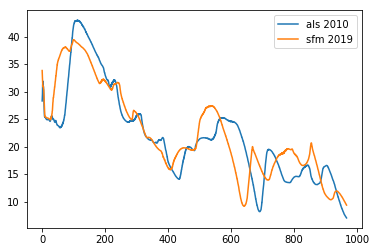

In [180]:
# plot
plt.plot(als_x,als_y,label='als 2010')
plt.plot(sfm_x,sfm_y,label='sfm 2019')
plt.legend()
# save svg
fig = dataDir + 'topo_profiles_als_sfm.svg'
plt.savefig(fig)

In [181]:
# end GRASS GIS session
os.remove(rcfile)